# MROCS :: Multiple Reward One Critic ( One State ) algorithm
---
Inspired + Implemented modifications of  : 
  - MADDPG - https://arxiv.org/pdf/1706.02275.pdf
    - single actor, possible multiple critics
  - k-step estimators + TD(0) learning ( advantage )
  - modified NoisyNetworks - https://arxiv.org/abs/1706.10295
    - multi head for actor ( see nes.py ) at explorer, share same nn.Linear, but differs in sigma+noise
    - renoising ( selected frequency ) only 1 randomly choosen layer per head
    - remove noise after every soft-update from explorer networks
    - soft-update is done on mean of all heads parameters ( see agent.py learn method )
  - SoftActor-Critic - https://arxiv.org/abs/1801.01290
  - Prioritized Experience Replay - https://arxiv.org/abs/1511.05952
    - however by default is plain random for now
  - postponed learning + soft sync + exploration renoising
  - Normalization - https://github.com/openai/baselines/blob/master/baselines/her/normalizer.py
    - see ac.py; batchnorm / globalnorm / identity
    - for this environment however seems most effective was identy ( aka not using normalization at all )
  - clipping gradients - https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html
    - for now we clipping by 1. norm
  - need to thanks following implementation : https://github.com/danielnbarbosa/angela
    - i used it heavily as benchmark for ideas before i was implementing my own version

Inovations ~ why MROCS ?
  - i am using same concept of critic accessing to all states as in MADDPG 
    - this can be used also for single player scenario ~ i will do project on it soon
  - in contrast with MADDPG, our critics compute multiple REWARD functions by single network
    - thus allowing only one critic
    - however multiple critics can work as well ( avoiding doing sudden changes ~ theory )
  - i think of only one actor playing with him self
    - now he need to know how he behaves not how the other agent does
      - learns what he need to do, so when other himself will be in game he will do job effectively ( cooperation )
      - to boost training, multiple heads ~ noise factor, is introduced
    - can be evaluated by multiple critics though
  - in current implementation i have coupled states+actions+rewards by time stamp ( how we experienced it )
    - later on i want to experiment with shuffling, however for multi agent environment this i think about it as feature
    - for single agent environments this i need to reconsider if it is a feature or bug ( decoupling is easy to do )

# one more word

I come with new MROCS algo, which is adaptation of MADDPG, however major difference is that
it have only one critic, and in this critic it approximate multiple reward functions at once.
As well as used NoisyNetworks for Actor, in a different way : detached heads for explorer network,
as they share same nn.Linear layers, however differs in sigma + noise. Target network Actor 
have only one head, and is updated as mean of explorer-heads.
To critic it goes all action from all actors, going trough linear encoding layer,
and cat with states ( which also goes for relu+linear encoding layer, so that i am trying 
to ensure signal from actors - actions, will have better position to affect states. If 
action_size is 1, and states_size is 300, then signal from actor to action-value function
have harder time to propagate i guess ~ theory ).

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from normalizer import *
from brain import *

# Unity Tennis envorinment specifics
agent = Brain(
        BatchNormalizer,
        n_rewards=2, detach=True, n_critics=1,
        n_history=1, state_size=24, action_size=2,
        learning_delay=100, learning_repeat=200, resample_delay=10,
        lr_actor=1e-4, lr_critic=1e-3, clip_norm=1.,
        n_step=3, gamma=.99, tau=1e-3, soft_sync=1,
        buffer_size=int(3e4), batch_size=256)

### 2. Instantiate the Environment and Agent

In [2]:
from unityagents import UnityEnvironment
ENV = UnityEnvironment(file_name='./data/Tennis.x86_64')
BRAIN_NAME = ENV.brain_names[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 3. Train the Agent with DDPG

In [3]:
def save_model():
    torch.save(agent.ac_explorer.state_dict(), 'checkpoint_explorer.pth')
    torch.save(agent.ac_target.state_dict(), 'checkpoint_target.pth')

def ddpg(max_t=1001, print_every=50):
    scores_deque = deque(maxlen=100)
    scores_deque.append(0)
    scores = []
    losses = []
    sc = 0
    max_s = 0
    while np.mean(scores_deque) < .5:
        n_states = deque(maxlen=agent.n_step)
        n_actions = deque(maxlen=agent.n_step)
        n_rewards = deque(maxlen=agent.n_step)

        discount = lambda: map(lambda j: n_rewards[j] * (agent.gamma ** j), range(agent.n_step))

        score = 0
        einfo = ENV.reset()[BRAIN_NAME]
        for t in range(max_t):
            states = einfo.vector_observations.copy()
            
            sc += 1
            loss = None if t <= agent.n_step else agent.step(
                    n_states[0],
                    n_actions[0],
                    np.vstack(discount()).sum(0),
                    states, sc)
            
            if loss is not None:
                losses.append(loss)
                    
            if sum(einfo.local_done):
                break
                    
            actions = agent.explore(states)
            einfo = ENV.step(actions.reshape(-1))[BRAIN_NAME]
            rewards = np.hstack(einfo.rewards)

            n_states.append(states)
            n_actions.append(actions)
            n_rewards.append(rewards)

            print('\r[{:6}] steps :: {:4} {:.2f} max_step::{:4} [replay::{}]'.format(
                    len(scores), t, score, max_s, len(agent.memory)), end="")

            max_s = max(max_s, t)
            score += rewards.mean()

        scores_deque.append(score)
        scores.append(score)

        print('\r{}Episode {}\tAverage Score: {:.2f} Recent {:.2f}'.format(
            (' ' * 60), len(scores), np.mean(scores_deque), score), end="")

        save_model()
        if len(scores) % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(len(scores), np.mean(scores_deque)))

    return scores, losses

scores, losses = ddpg()

Episode 50	Average Score: 0.00                              Episode 50	Average Score: 0.00 Recent 0.1500
Episode 100	Average Score: 0.00                             Episode 100	Average Score: 0.00 Recent -0.00
Episode 150	Average Score: 0.01                             Episode 150	Average Score: 0.01 Recent -0.00
Episode 200	Average Score: 0.04                             Episode 200	Average Score: 0.04 Recent 0.100
Episode 250	Average Score: 0.11                             Episode 250	Average Score: 0.11 Recent 0.050
Episode 300	Average Score: 0.12                             Episode 300	Average Score: 0.12 Recent 0.400
Episode 350	Average Score: 0.34                             Episode 350	Average Score: 0.34 Recent 0.100
Episode 400	Average Score: 0.42                             Episode 400	Average Score: 0.42 Recent 0.150
Episode 450	Average Score: 0.39                             Episode 450	Average Score: 0.39 Recent 0.050
Episode 500	Average Score: 0.46                        

### 4. Plot reward + loss

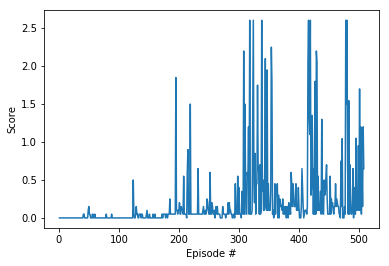

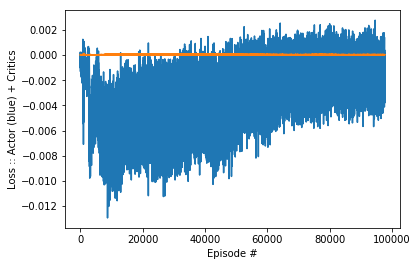

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

losses = np.vstack(losses)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses)
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

### 4.Reload trained agent

In [5]:
agent.ac_explorer.load_state_dict(torch.load('checkpoint_explorer.pth'))
agent.ac_target.load_state_dict(torch.load('checkpoint_target.pth'))

### 5. Test visuals - EXPLORER

runtime mean rewards :  0.1723000027704984


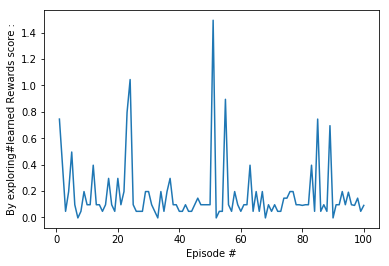

In [6]:
import time
rewards = []
for _ in range(100):
    rewards.append(0)
    einfo = ENV.reset()[BRAIN_NAME]
    while not sum(einfo.local_done):
#        time.sleep(1/50)
        states = einfo.vector_observations.copy()
        actions = agent.explore(states)
        einfo = ENV.step(actions.reshape(-1))[BRAIN_NAME]
        rewards[-1] += np.hstack(einfo.rewards).mean()
        
print("runtime mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - TARGET

true mean rewards :  1.427800021385774


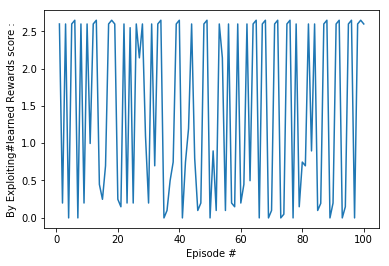

In [7]:
rewards = []
for _ in range(100):
    rewards.append(0)
    einfo = ENV.reset()[BRAIN_NAME]
    while not sum(einfo.local_done):
        states = einfo.vector_observations.copy()
        actions = agent.exploit(states)
        einfo = ENV.step(actions.reshape(-1))[BRAIN_NAME]
        rewards[-1] += np.hstack(einfo.rewards).mean()
        
print("true mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 

### 7. Close environment, we are done!

In [8]:
#ENV.close()